In [1]:
#Libraries
using Gen
using PyPlot
using Distributions
using LinearAlgebra
using Flux
using Random
using Distances;

In [140]:
#------------------------------------
#Hyperparameters and Helper Functions
#------------------------------------

#Select Network Goal
#network = "classifier"
network = "interpolator"

#Data hyperparameters
n = 200 #Number of samples per mode (classifier)
m = 4 #Number of modes (classifier)
d = 2 #Input dimension
N = n*4 #Total samples
σₐ = 0.1 #Mode variance (classifier)
bound = 1.0 #Axis bound

#Network hyperparameters
α = 0.0009 #Regularization term
σₖ = sqrt(1/α) #Network parameter variances
σᵧ = 0.002

#Node hyperparameters
k_range = 12 #Maximum number of neurons per layer
k_list = [Int(i) for i in 1:k_range]
l_range = 5 #Maximum number of layers in the network
l_list = [Int(i) for i in 1:l_range]
l_real = 3
k_real = [5,8,3]
k = k_real;

#Helper Functions
function plot_data(data,scores,alpha=1.0)
    PyPlot.scatter(data[:,1],data[:,2],c=scores,alpha=alpha)
    #PyPlot.colorbar()
end

function plot_contour(data, scores, alpha=1.0)
    PyPlot.contour(data[:,1],data[:,2],c=scores)
end

function sample_data(x, y, n=N)
    perm = randperm(length(x[1,:]))[1:n]
    x_new1 = [x[1,perm[i]] for i=1:n]
    x_new2 = [x[2,perm[i]] for i=1:n]
    x_new = hcat(x_new1,x_new2)
    return x_new, y[perm]
end

function layer_unpacker(i,l,k)
    if i == 1
        input_dim = d
        output_dim = k[i]
    else
        input_dim = k[i-1]
        output_dim = k[i]
    end
    return input_dim, output_dim
end;

In [142]:
#-------------------------------
#Generative Interpolator Network
#-------------------------------

#Bayesian Neural Net
function G(x, trace)
    activation = sigmoid
    layers = trace[:l]
    ks = [trace[(:k,i)] for i=1:layers]
    for i=1:layers
        in_dim, out_dim = layer_unpacker(i, layers, ks)
        W = reshape(trace[(:W,i)], out_dim, in_dim)
        b = reshape(trace[(:b,i)], trace[(:k,i)])
        nn = Dense(W, b, activation)
        x = nn(x)
    end
    
    Wₒ = reshape(trace[:Wₒ], 1, ks[layers])
    bₒ = reshape(trace[:bₒ],1)
    
    nn_out = Dense(Wₒ, bₒ)
    return nn_out(x)
end;

#Create a Random Network
@gen function generator()

    #Draw number of layers
    l ~ categorical([1/length(l_list) for i=1:length(l_list)])
    l_real = l
    
    #Create individual weight and bias vectors
    
    #Loop through hidden layers
    k = [Int(0) for i=1:l]
    for i=1:l
        k[i] = @trace(categorical([1/length(k_list) for i=1:length(k_list)]), (:k,i))
    end
    
    #Sample weight and parameter vectors
    W = [zeros(k[i]) for i=1:l]
    b = [zeros(k[i]) for i=1:l]
    for i=1:l
        if i == 1
            h = Int(d * k[i])
        else
            h = Int(k[i-1] * k[i])
        end

        μ = zeros(h)
        Σ = Diagonal([σₖ for i=1:length(μ)])
        W[i] = @trace(mvnormal(μ,Σ), (:W,i))
        
        μ2 = ones(k[i])
        Σ2 = Diagonal([σₖ for i=1:length(μ2)])
        b[i] = @trace(mvnormal(μ2,Σ2), (:b,i))
    end
    
    #Output Weights
    μₒ = zeros(k[l])
    Σₒ = Diagonal([σₖ for i=1:length(μₒ)])
    Wₒ ~ mvnormal(μₒ,Σₒ)
    
    #Output Bias
    μ2ₒ = ones(1)
    Σ2ₒ = Diagonal([σₖ for i=1:length(μ2ₒ)])
    bₒ ~ mvnormal(μ2ₒ,Σ2ₒ)
    
end;

In [73]:
#Test out Generator function so far
obs = choicemap()::ChoiceMap

(trace,) = generate(generator, (), obs)
#println(trace[:l])
#println([trace[(:k,i)] for i=1:trace[:l]])
#println([trace[(:W,i)] for i=1:trace[:l]])
#println([trace[(:b,i)] for i=1:trace[:l]])

1
9
1
[9]
[[0.07534740374604776, 1.6001570607041313, 0.3191568287739998, -1.1290902493976192, 1.0183480695716651, -1.1646203443533865, 0.429057291415087, -0.8854202517616505, -0.619739863808692, 0.1667280072030557, 0.5957084343279804, 0.7243645507711416, -0.9094702036842975, -2.335237912864742, 1.7484451046025895, -0.8848649020208607, 0.6413613262006242, 1.6877371065552655]]
[[-0.1598490443966769, 2.567009361455983, 1.3326945210969898, -0.784897187059153, 0.8410174026408901, 2.12029252621136, 2.455393464661662, 2.3197496477248025, -0.7934341926077706]]


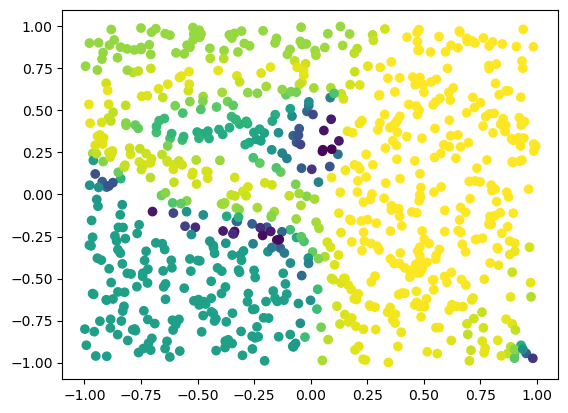

[11, 11, 10, 11, 8]


PyObject <matplotlib.collections.PathCollection object at 0x7f1b77c086d0>

In [147]:
#---------------------------------------------------
#Generate Network Parameters and Corresponding Curve
#---------------------------------------------------
obs = choicemap()::ChoiceMap
x_raw = rand(Uniform(-bound,bound),(N,2))
x = transpose(x_raw)
data = x
data_raw = x_raw

(trace,) = generate(generator, (), obs)
println([trace[(:k,i)] for i=1:trace[:l]])

y_real = Flux.σ.(G(x,trace)[1,:])
#ϵ = [normal(0.0,0.05) for i=1:length(y_real)]
#print(ϵ)
#y_real += ϵ
#print(y_real)

plot_data(x_raw,y_real)

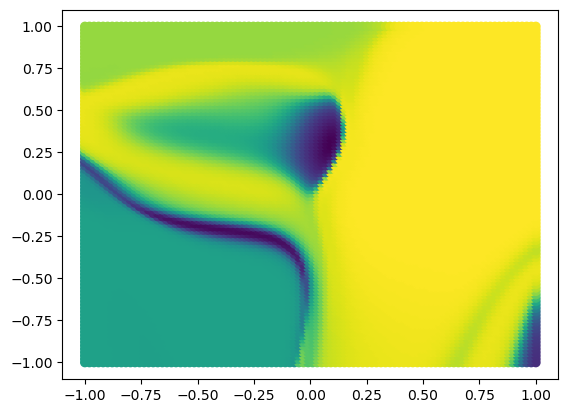

In [149]:
function creategrid(d::Integer, n::Integer, low::Float64, high::Float64)

    @assert d >= 1 ("d (number of dimensions) must be a positive integer")
    @assert n >= 2 ("n (number of points) must be a at least 2")

    r = range(low, high, length = n)

    iter = Iterators.product((r for _ in 1:d)...)

    return vec([collect(i) for i in iter])
end

grid = creategrid(2,100,-bound,bound)
grid_raw = reduce(hcat, getindex.(grid,i) for i in eachindex(grid[1]))
grid2 = transpose(grid_raw)
z = Flux.σ.(G(grid2,trace))[1,:]
plot_data(grid_raw, z);

In [152]:
#Classifier Network Tries to Learn the Generator Network

@gen function classifier(x::Array{Float64})
    #Prepare ChoiceMap to send through to BNN (G)
    obs = choicemap()::ChoiceMap

    #Draw number of layers
    l ~ categorical([1/length(l_list) for i=1:length(l_list)])
    l_real = l
    obs[:l] = l
    
    #Create individual weight and bias vectors
    #Loop through hidden layers
    k = [Int(0) for i=1:l]
    for i=1:l
        k[i] = @trace(categorical([1/length(k_list) for i=1:length(k_list)]), (:k,i))
        obs[(:k,i)] = k[i]
    end
    
    #Sample weight and parameter vectors
    W = [zeros(k[i]) for i=1:l]
    b = [zeros(k[i]) for i=1:l]
    for i=1:l
        if i == 1
            h = Int(d * k[i])
        else
            h = Int(k[i-1] * k[i])
        end

        μ = zeros(h)
        Σ = Diagonal([σₖ for i=1:length(μ)])
        W[i] = @trace(mvnormal(μ,Σ), (:W,i))
        obs[(:W,i)] = W[i]
        
        μ2 = ones(k[i])
        Σ2 = Diagonal([σₖ for i=1:length(μ2)])
        b[i] = @trace(mvnormal(μ2,Σ2), (:b,i))
        obs[(:b,i)] = b[i]
    end
    
    #Output Weights
    μₒ = zeros(k[l])
    Σₒ = Diagonal([σₖ for i=1:length(μₒ)])
    Wₒ ~ mvnormal(μₒ,Σₒ)
    obs[:Wₒ] = Wₒ
    
    #Output Bias
    μ2ₒ = ones(1)
    Σ2ₒ = Diagonal([σₖ for i=1:length(μ2ₒ)])
    bₒ ~ mvnormal(μ2ₒ,Σ2ₒ)
    obs[:bₒ] = bₒ
    
    scores = G(x,obs)
    scores = Flux.σ.(scores)
    
    #Regression Likelihood
    y = @trace(mvnormal(vec(scores), Diagonal([σᵧ for i=1:length(x[1,:])])), (:y))
    
    return y
end;

classifier(x);

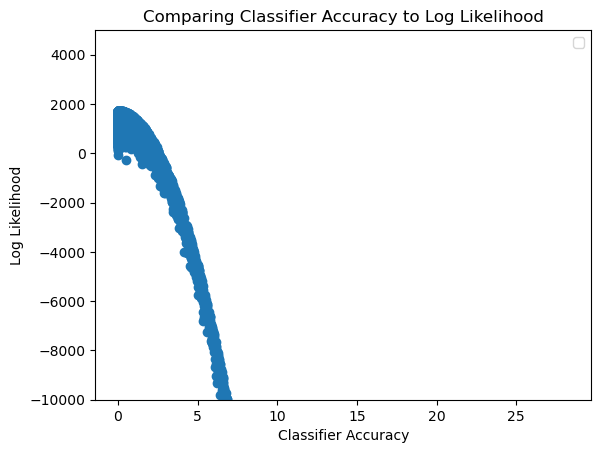

No handles with labels found to put in legend.


PyObject <matplotlib.legend.Legend object at 0x7f1b77684390>

In [189]:
#-----------------------------------------
#Register Observed Data - Test Likelihood
#-----------------------------------------

obs_master = choicemap()::ChoiceMap
obs_master[:y] = y_real
obs = obs_master;

scores = []
distances = []
ls = []
best_ls = []
best_traces = []
(best_trace,) = generate(classifier, (x,), obs)
best_score = get_score(best_trace)
best_l = best_trace[:l]

best_pred_y = Flux.σ.(G(x,best_trace))
best_dist = euclidean(best_pred_y, y_real)

function likelihood(best_trace, best_dist, best_score, best_l)
    obs = obs_master;
    (trace,) = generate(classifier, (x,), obs)
    pred_y = Flux.σ.(G(x,trace))

    dist = euclidean(pred_y, y_real)
    score = get_score(trace)
    #println(score)
    if score > get_score(best_trace)
        best_dist = dist
        best_score = score
        best_trace = trace
        best_pred_y = pred_y
        best_l = best_trace[:l]
    end
    #push!(best_ks,best_k)
    push!(scores,score)
    push!(distances,dist)
    #push!(ls, l)
    #println(best_score)
    return(best_trace, best_dist, best_score, best_l)
end;

for i=1:10000
    best_trace, best_dist, best_score, best_l = likelihood(best_trace, best_dist, best_score, best_l)
    push!(best_ls, best_l)
end

PyPlot.scatter(distances, scores)
plt.title("Comparing Classifier Accuracy to Log Likelihood")
plt.xlabel("Classifier Accuracy")
plt.ylabel("Log Likelihood")
plt.ylim(-10000,5000)
plt.legend()